Importing Data

In [ ]:
!pip install wfdb==3.4.0
!wget -q https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip -qo /content/mit-bih-arrhythmia-database-1.0.0.zip 
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 2.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.7 MB/s eta 0:00:00


Getting data into usable Arrays

0       973
1       974
2       974
3       971
4       973
       ... 
2995    966
2996    963
2997    962
2998    964
2999    964
Name: ecg, Length: 3000, dtype: int64


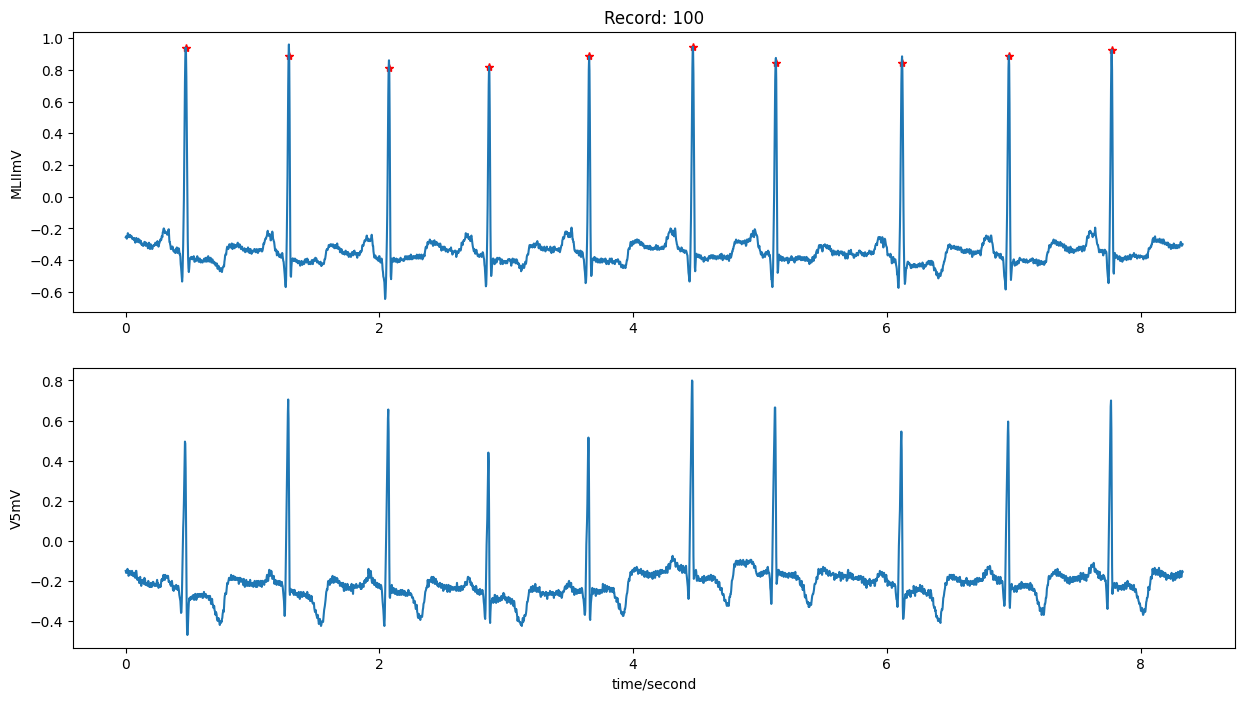

360


In [ ]:
import statistics 
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import signal
from scipy.misc import derivative

data = 100
length = 3200
order = 1
t = np.linspace(0, 1, length, endpoint=False)

filename = f'/content/mit-bih-arrhythmia-database-1.0.0/{str(data)}'
record = wfdb.rdrecord(filename, sampfrom=200, sampto=length,)
ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T, columns=['TimeStamp','ecg'])

# Self Notes: this retrieves all the rows of data, and extracts only column 1
input = ecg.iloc[:,1]
print(input)

annotation = wfdb.rdann(filename, 'atr', sampfrom=200, sampto=length,shift_samps=True)
Fs = annotation.fs

wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds',figsize=(15,8))

# Testing
print(annotation.fs)

360


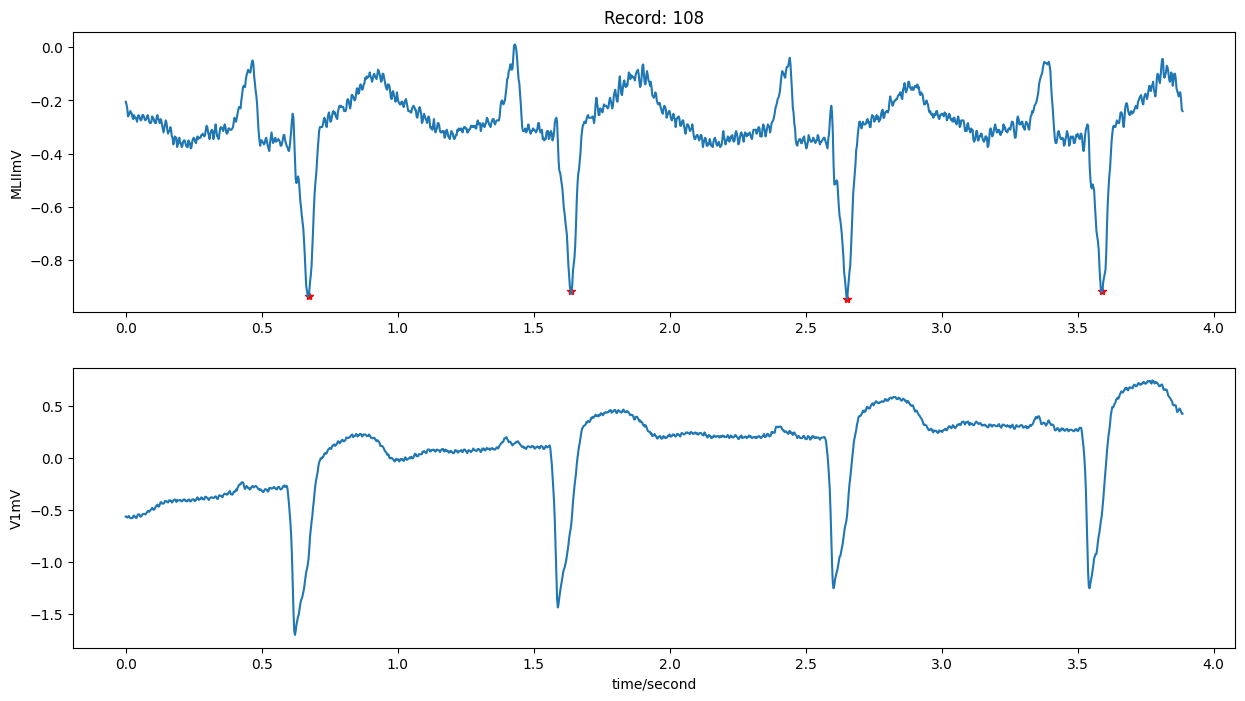

In [ ]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.misc import derivative

data = 108
length = 1600
order = 1
t = np.linspace(0, 1, length, endpoint=False)

filename = f'mit-bih-arrhythmia-database-1.0.0/{str(data)}'
record = wfdb.rdrecord(filename, sampfrom=200, sampto=length,)
ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])
input = ecg.iloc[:,1]

annotation = wfdb.rdann(filename, 'atr', sampfrom=200, sampto=length,shift_samps=True)
Fs = annotation.fs #obtaining Sampling Frequency from annotation file
print(Fs)

wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds',figsize=(15,8))
  

ECG Signal Simulation

In [ ]:
import logging
import threading
import time

# The goal is to have a thread running alongside the main program which will
# output the necessary ecg data (which may affect timing results). 
class ECG_Simulator():

  def __init__(self, ecg, sample_freq):
    self.ecg = ecg
    self.current_ecg = 0.0
    self.new_val = False
    self.sample_freq = sample_freq
    self.not_finished = True

    self.ecg_index = 0
    self.ecg_progress = widgets.IntProgress(
      value=self.ecg_index,
      min=0,
      max=len(self.ecg),
      description='Progress:',
      bar_style='info',
      style={'bar_color': '#1E90FF'},
      orientation='horizontal'
    )
    display(self.ecg_progress)

  def simulate(self):
    for ecg_reading in self.ecg:
      self.ecg_progress.value = self.ecg_index
      self.ecg_index += 1

      self.current_ecg = ecg_reading
      self.new_val = True
      # print(self.current_ecg)
      # logging.info(self.current_ecg)
      time.sleep(1/self.sample_freq) # Based on the sampling rate
    
    self.not_finished = False

  # To be used along with the main algorithm, which generally should get, store
  # and operate on the ECG data.
  def checkECG(self):
    check = self.new_val
    self.new_val = False
    return check

  def checkNotFinished(self):
    return self.not_finished


  def getECG(self):
    return self.current_ecg

# Testing Purposes

# print("Starting")
# simulator = ECG_Simulator(input)
# sim = threading.Thread(target = simulator.simulate)
# sim.start()

# while True:
#   print(simulator.getECG())
#   time.sleep(1)

# sim.join()

Pan-Tompkins Filters & Algorithm

In [ ]:
# This piece of code really runs more like a script than a class (if that's even
# the correct term for it), the functions decribed here should really be run
# sequentially (generally)
class ECG_Solver():

  def __init__(self):
    # ----- OTHER STUFF ----- #
    # some widgets to better display data
    self.hr_widget = widgets.FloatText(value=0, description='HR (bpm):', disabled=False)
    self.diag_widget = widgets.Text(value='Unknown', description='Diagnosis:', disabled=False)
    display(self.hr_widget)
    display(self.diag_widget)
    
    # ----- PREPROCESSING VARIABLES ----- #
    self.buff_size = 600

    # Buffers
    self.ecg_raw = np.zeros(self.buff_size)
    self.ecg_lp = np.zeros(self.buff_size)
    self.ecg_hp = np.zeros(self.buff_size)
    self.ecg_der = np.zeros(self.buff_size)
    self.ecg_sqr = np.zeros(self.buff_size)
    self.ecg_win = np.zeros(self.buff_size)
    
    self.raw_index = -1
    self.lp_index = -1
    self.hp_index = -1
    self.hp_dindex = -1 # Used to account for x(nT+2T)
    self.der_index = -1
    self.sqr_index = -1
    self.win_index = -1

    self.win_size = round(0.150 * Fs) # need to double check this (not sure how this is derived)
    self.ecg_sqr_win = np.zeros(self.win_size)
    self.sqr_win_index = -1

    self.lpout_1 = 0 # low pass y(nT-T)
    self.lpout_2 = 0 # low pass y(nT-2T)
    self.hpout_1 = 0 # high pass y(nT-T)

    # ----- PEAK DETECTION ALG. VARIABLES ----- #
    self.delay = 22

    self.out_signal = np.zeros(self.buff_size, dtype=bool)
    self.out_index = -1

    self.sample = 0 # need to implement/fix
    self.lastQRS = 0 # need to implement/fix

    self.threshold_i1 = 0
    self.threshold_i2 = 0
    self.threshold_f1 = 0
    self.threshold_f2 = 0

    self.peak_i = 0
    self.peak_f = 0

    self.spk_i = 0
    self.spk_f = 0
    self.npk_i = 0
    self.npk_f = 0

    self.current_slope = 0
    self.last_slope = 0

    self.rr1 = np.zeros(8)
    self.rr2 = np.zeros(8)
    self.rravg1 = None
    self.rravg2 = None
    self.rrlow = 0
    self.rrhigh = 0
    self.rrmiss = 0

    # boolean variables
    self.qrs = False
    self.regular = True
    self.prev_regular = None

    # ----- HEART RATE & CLASSIFIER VARIABLES ----- #
    self.sample_timer = 0 # time based on sampling frequency
    self.sp1 = False
    self.sp2 = False

    self.rr_intervals = []
  
    # ----- PREPROCESSING METHODS ----- #

  def getBuffSize(self):
    return self.buff_size

  def readECG(self, inputData):
    # from the github referenced for finding peaks, used to count samples read
    self.sample += 1

    # array shuffling for each new value added (maybe this could be faster if
    # implemented in hardware?)
    if (self.raw_index != self.buff_size - 1):
      self.raw_index += 1
    else:
      self.ecg_raw = np.roll(self.ecg_raw, -1)

    self.ecg_raw[self.raw_index] = inputData

    return self.ecg_raw

  # Below they should be considered as private functions, but this may be tentative

  def lpFilter(self):
  
    # array shuffling for each new value added (maybe this could be faster if
    # implemented in hardware?)
    if (self.lp_index != self.buff_size - 1):
      self.lp_index += 1
    else:
      self.ecg_lp = np.roll(self.ecg_lp, -1)

    # y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)
    self.ecg_lp[self.lp_index] = 2 * self.lpout_1 - self.lpout_2 + self.ecg_raw[self.raw_index] 

    if (self.raw_index >= 6):
      self.ecg_lp[self.lp_index] -= 2 * self.ecg_raw[self.raw_index - 6]

    if (self.raw_index >= 12):
      self.ecg_lp[self.lp_index] += self.ecg_raw[self.raw_index - 12]

    self.lpout_2 = self.lpout_1
    self.lpout_1 = self.ecg_lp[self.lp_index]

    return self.ecg_lp

  def hpFilter(self):

    # array shuffling for each new value added (maybe this could be faster if
    # implemented in hardware?)
    if (self.hp_index != self.buff_size - 1):
      self.hp_index += 1
      # subtract 2 below because of x(nT + 2T) for derivative
      if (self.hp_dindex != self.buff_size - 1 - 2 and self.hp_index >= 2):
        self.hp_dindex += 1
    else:
      self.ecg_hp = np.roll(self.ecg_hp, -1)

    # y(nT) = 32x(nT - 16T) - y(nT - T) - x(nT) + x(nT - 32T)
    self.ecg_hp[self.hp_index] = -1 * (self.hpout_1 + self.ecg_lp[self.lp_index])

    if (self.lp_index >= 16):
      self.ecg_hp[self.hp_index] += 32 * self.ecg_lp[self.lp_index - 16]

    if (self.lp_index >= 32):
      self.ecg_hp[self.hp_index] += self.ecg_lp[self.lp_index - 32]

    self.hpout_1 = self.ecg_hp[self.hp_index]

    return self.ecg_hp

  def derFilter(self):
    # array shuffling for each new value added (maybe this could be faster if
    # implemented in hardware?)
    if (self.der_index != self.buff_size - 1):
      self.der_index += 1
    else:
      self.ecg_der = np.roll(self.ecg_der, -1)

    # y(nT) = [-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]/(8T)
    self.ecg_der[self.der_index] = 0

    if (self.hp_index >= 4):

      # legacy: if (self.hp_index >= 1):
      self.ecg_der[self.der_index] -= self.ecg_hp[self.hp_dindex - 1]

      # legacy: if (self.hp_index >= 2):
      self.ecg_der[self.der_index] -= self.ecg_hp[self.hp_dindex - 2]
    
      # legacy: if (self.hp_index >= 3):
      self.ecg_der[self.der_index] += self.ecg_hp[self.hp_dindex + 1]

      self.ecg_der[self.der_index] += self.ecg_hp[self.hp_dindex + 2]
    
    # Double check this, may be as below (Fs is sampling frequency)
    # self.ecg_der = (self.ecg_der * Fs) /8
    self.ecg_der[self.der_index] /= 8
    
    return self.ecg_der

  def squaring(self):

    # array shuffling for each new value added (maybe this could be faster if
    # implemented in hardware?)
    if (self.sqr_index != self.buff_size - 1):
        self.sqr_index +=1
    else:
      self.ecg_sqr = np.roll(self.ecg_sqr, -1)
      
    if (self.sqr_win_index != self.win_size - 1):
      self.sqr_win_index += 1
    else:
      self.ecg_sqr_win = np.roll(self.ecg_sqr_win, -1)

    # y(nT) = [x(nT)]^2
    self.ecg_sqr[self.sqr_index] = self.ecg_der[self.der_index]**2
    self.ecg_sqr_win[self.sqr_win_index] = self.ecg_der[self.der_index]**2

    return self.ecg_sqr

  def winIntegrator(self):

    # array shuffling for each new value added (maybe this could be faster if
    # implemented in hardware?)
    if (self.win_index != self.buff_size - 1):
      self.win_index += 1
    else:
      self.ecg_win = np.roll(self.ecg_win, -1)

    # y(nT) = [y(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]/N
    self.ecg_win[self.win_index] = 0

    for i in range(self.win_size):
        self.ecg_win[self.win_index] += self.ecg_sqr_win[i]
    
    self.ecg_win[self.win_index] /= self.win_size
    
    return self.ecg_win;

  # ----- PEAK DETECTION ALG. METHODS ----- #

  # this is a python code conversion from the github link:
  # https://github.com/rafaelmmoreira/PanTompkinsQRS/blob/master/panTompkins.c
  # where I have extracted the section on finding r-peaks and post-processing
  def find_peaks(self):
    self.qrs = False

    if (self.ecg_win[self.win_index] >= self.threshold_i1 
        or self.ecg_hp[self.hp_index] >= self.threshold_f1):
      self.peak_i = self.ecg_win[self.win_index]
      self.peak_f = self.ecg_hp[self.hp_index]

    if (self.ecg_win[self.win_index] >= self.threshold_i1 
        and self.ecg_hp[self.hp_index] >= self.threshold_f1):
      if(self.sample > self.lastQRS + int(Fs / 5)):
        if(self.sample <= self.lastQRS +  0.36 * Fs): # check this over
          self.current_slope = 0

          # + 1 for inclusiveness
          for i in range(self.sqr_index - 10, self.sqr_index + 1):
            if (self.ecg_sqr[i] > self.current_slope):
              self.current_slope = self.ecg_sqr[i]
          
          if (self.current_slope <= self.last_slope / 2):
            self.qrs = False
          else:
            self.spk_i = 0.125 * self.peak_i + 0.875 * self.spk_i
            self.threshold_i1 = self.npk_i + 0.25 * (self.spk_i - self.npk_i)
            self.threshold_i2 = 0.5 * self.threshold_i1

            self.spk_f = 0.125 * self.peak_f + 0.875 * self.spk_f
            self.threshold_f1 = self.npk_f + 0.25 * (self.spk_f - self.npk_f)
            self.threshold_f2 = 0.5 * self.threshold_f1

            self.last_slope = self.current_slope
            self.qrs = True

        else:
          self.current_slope = 0

          # + 1 for inclusiveness
          for i in range(self.sqr_index - 10, self.sqr_index + 1):
            if (self.ecg_sqr[i] > self.current_slope):
              self.current_slope = self.ecg_sqr[i]

          self.spk_i = 0.125 * self.peak_i + 0.875 * self.spk_i
          self.threshold_i1 = self.npk_i + 0.25 * (self.spk_i - self.npk_i)
          self.threshold_i2 = 0.5 * self.threshold_i1

          self.spk_f = 0.125 * self.peak_f + 0.875 * self.spk_f
          self.threshold_f1 = self.npk_f + 0.25 * (self.spk_f - self.npk_f)
          self.threshold_f2 = 0.5 * self.threshold_f1

          self.last_slope = self.current_slope
          self.qrs = True


      else:
        self.peak_i = self.ecg_win[self.win_index]
        
        self.npk_i = 0.125 * self.peak_i + 0.875 * self.npk_i
        self.threshold_i1 = self.npk_i + 0.25 * (self.spk_i - self.npk_i)
        self.threshold_i2 = 0.5 * self.threshold_i1

        self.peak_f = self.ecg_hp[self.hp_index]
        self.npk_f = 0.125 * self.peak_f + 0.875 * self.npk_f
        self.threshold_f1 = self.npk_f + 0.25 * (self.spk_f - self.npk_f)
        self.threshold_f2 = 0.5 * self.threshold_f1

        self.qrs = False
        
        # tentative below
        # array shuffling for each new value added (maybe this could be faster if
        # implemented in hardware?)
        if (self.out_index != self.buff_size - 1):
          self.out_index += 1
        else:
          self.out_signal = np.roll(self.out_signal, -1)

        self.out_signal[self.out_index] = self.qrs

        # super tentative, below kinda violates my sequentially handling in the
        # executable code since my flow control is very shallow (i.e.
        # script <--> public functions )
        if (self.sample > self.delay + self.buff_size):
          self.output(self.out_signal[0]) # maybe change this as well

        return self.out_signal # gotta check this out

    # also tentative
    if (self.qrs):
      self.rravg1 = 0

      for i in range(7):
        self.rr1[i] = self.rr1[i + 1]
        self.rravg1 += self.rr1[i]

      self.rr1[7] = self.sample - self.lastQRS
      self.lastQRS = self.sample
      self.rravg1 += self.rr1[7]
      self.rravg1 *= 0.125

      if ((self.rr1[7] >= self.rrlow) and (self.rr1[7] <= self.rrhigh)):
        self.rravg2 = 0

        for i in range(8):
          self.rr2[i] = self.rr2[i + 1];
          self.rravg2 += self.rr2[i]
        
        self.rr2[7] = self.rr1[7]
        self.rravg2 += self.rr2[7]
        self.rravg2 *= 0.125
        self.rrlow = 0.92 * self.rravg2
        self.rrhigh = 1.16 * self.rravg2
        self.rrmiss = 1.66 * self.rravg2

      self.prev_regular = self.regular
      if (self.rravg1 == self.rravg2):
        self.regular = True
      else:
        self.regular = False
        if (self.prev_regular):
          self.threshold_i1 /= 2
          self.threshold_f1 /= 2

    else:  
      if ((self.sample - self.lastQRS > self.rrmiss) and (self.sample > self.lastQRS + int(Fs / 5))): # check this over

        # slight modification since I don't use a global index (but hopefully
        # still works the same). May also use a global index instead, since all
        # the indexes should theoretically also += 1 every execution.
        current = self.hp_index # make modifications to this in case I do use a global index

        # debugging
        # print("sample: " + str(self.sample))
        # print("lastQRS:" + str(self.lastQRS))

        if (self.hp_index != self.win_index):
          print("Warning: index mismatch - possible error or misuse")

        for i in range (current - (self.sample - self.lastQRS) + int(Fs / 5), current):
          if ((self.ecg_win[i] > self.threshold_i2) and (self.ecg_hp[i] > self.threshold_f2)):
            self.current_slope = 0

            # + 1 for inclusiveness
            for j in range(i - 10, i + 1):
              if (self.ecg_sqr[j] > self.current_slope):
                self.current_slope = self.ecg_sqr[j]
            
            if ((self.current_slope < self.last_slope / 2) and (i + self.sample) < self.lastQRS + 0.36 * self.lastQRS):
              self.qrs = False
            else:
              self.peak_i = self.ecg_win[i];
              self.peak_f = self.ecg_hp[i];
              self.spk_i = 0.25 * self.peak_i + 0.75 * self.spk_i;
              self.spk_f = 0.25 * self.peak_f + 0.75 * self.spk_f;
              self.threshold_i1 = self.npk_i + 0.25 * (self.spk_i - self.npk_i);
              self.threshold_i2 = 0.5 * self.threshold_i1;
              self.last_slope = self.current_slope;
              self.threshold_f1 = self.npk_f + 0.25 * (self.spk_f - self.npk_f);
              self.threshold_f2 = 0.5 * self.threshold_f1

              self.rravg1 = 0
              for j in range(0, 7):
                self.rr1[j] = self.rr1[j + 1]
                self.rravg1 += self.rr1[j]
              
              self.rr1[7] = self.sample - (current - i) - self.lastQRS;
              self.qrs = True;
              self.lastQRS = self.sample - (current - i);
              self.rravg1 += self.rr1[7];
              self.rravg1 *= 0.125

              self.prev_regular = self.regular
              if (self.rravg1 == self.rravg2):
                self.regular = True
              else:
                self.regular = False
                if(self.prev_regular):
                  self.threshold_i1 /= 2
                  self.threshold_f1 /= 2

              break

        if (self.qrs):
          self.out_signal[current] = False;
          self.out_signal[i] = True;
          if (self.sample > self.delay + self.buff_size):
            self.output(self.out_signal[0]);

          return self.out_signal # gotta check this out

      if (not self.qrs):
        if (self.ecg_win[self.win_index] >= self.threshold_i1 
        or self.ecg_hp[self.hp_index] >= self.threshold_f1):
          self.peak_i = self.ecg_win[self.win_index]
          self.npk_i = 0.125 * self.peak_i + 0.875 * self.npk_i;
          self.threshold_i1 = self.npk_i + 0.25 * (self.spk_i - self.npk_i);
          self.threshold_i2 = 0.5 * self.threshold_i1;
          self.peak_f = self.ecg_hp[self.hp_index];
          self.npk_f = 0.125 * self.peak_f + 0.875 * self.npk_f;
          self.threshold_f1 = self.npk_f + 0.25 * (self.spk_f - self.npk_f);
          self.threshold_f2 = 0.5 * self.threshold_f1;

    # array shuffling for each new value added (maybe this could be faster if
    # implemented in hardware?)
    if (self.out_index != self.buff_size - 1):
      self.out_index += 1
    else:
      self.out_signal = np.roll(self.out_signal, -1)

    self.out_signal[self.out_index] = self.qrs

    # super tentative, below kinda violates my sequentially handling in the
    # executable code since my flow control is very shallow (i.e.
    # script <--> public functions )
    if (self.sample > self.delay + self.buff_size):
      self.output(self.out_signal[0]) # maybe change this as well

    return self.out_signal

    # note that it might be also a good idea to implement a method to finish
    # outputting the last items in the buffer

  # ----- HEART RATE & CLASSIFIER METHODS -----

  # Note that due to the buffer, the output is delayed by 600 * sample freq.
  def output(self, qrs):
    self.sample_timer += 1

    if (qrs):
      self.sp1 = self.sp2
      self.sp2 = qrs

      if (self.sp1):
        hr = 60 * Fs / self.sample_timer
        self.rr_intervals.append(self.sample_timer / Fs)

        self.hr_widget.value = hr

        if (hr < 60):
          self.diag_widget.value = "Bradycardia"
        elif (hr > 100):
          self.diag_widget.value = "Tachycardia"
        else:
          self.diag_widget.value = "Normal"

      self.sample_timer = 0

  def getDiagnosis(self):
    # SDNN, though only as long as the recording
    SDNN = statistics.stdev(self.rr_intervals)
    
    if (SDNN < 0.05):
      return "high risk"
    elif (SDNN < 0.1):
      return "moderate risk"
    else:
      return "low risk"


Testing & Graphs

In [ ]:
0print("Starting...\n")

simulator = ECG_Simulator(input, Fs)
solver = ECG_Solver()
sim = threading.Thread(target = simulator.simulate)
sim.start()

test_data_r = []
test_data_l = []
test_data_h = []
test_data_d = []
test_data_s = []
test_data_w = []
test_data_o = []

initial_phase = True

while simulator.checkNotFinished():
  if (initial_phase):
    i = 0
    while i < 600:
      if (simulator.checkECG()):

        solver.readECG(simulator.getECG())
        solver.lpFilter()
        solver.hpFilter()
        solver.derFilter()
        solver.squaring()
        solver.winIntegrator()
        solver.find_peaks()
        i += 1

    initial_phase = False
  else:
    if (simulator.checkECG()):
      # test_data_r.append(solver.readECG(simulator.getECG())[solver.getBuffSize() - 1])
      # test_data_l.append(solver.lpFilter()[solver.getBuffSize() - 1])
      # test_data_h.append(solver.hpFilter()[solver.getBuffSize() - 1])
      # test_data_d.append(solver.derFilter()[solver.getBuffSize() - 1])
      # test_data_s.append(solver.squaring()[solver.getBuffSize() - 1])
      # test_data_w.append(solver.winIntegrator()[solver.getBuffSize() - 1])
      # test_data_o.append(solver.find_peaks()[solver.getBuffSize() - 1])

      test_data_r.append(solver.readECG(simulator.getECG())[0])
      test_data_l.append(solver.lpFilter()[0])
      test_data_h.append(solver.hpFilter()[0])
      test_data_d.append(solver.derFilter()[0])
      test_data_s.append(solver.squaring()[0])
      test_data_w.append(solver.winIntegrator()[0])
      test_data_o.append(solver.find_peaks()[0])

# print("\n---\n")

sim.join()

print("\nFinished.")

print("\n-----> Patient is at " + solver.getDiagnosis() + " of myocardial infarction or chronic heart failure. <-----")

Starting...



IntProgress(value=0, bar_style='info', description='Progress:', max=1400, style=ProgressStyle(bar_color='#1E90…

FloatText(value=0.0, description='HR (bpm):')

Text(value='Unknown', description='Diagnosis:')


Finished.


StatisticsError: ignored

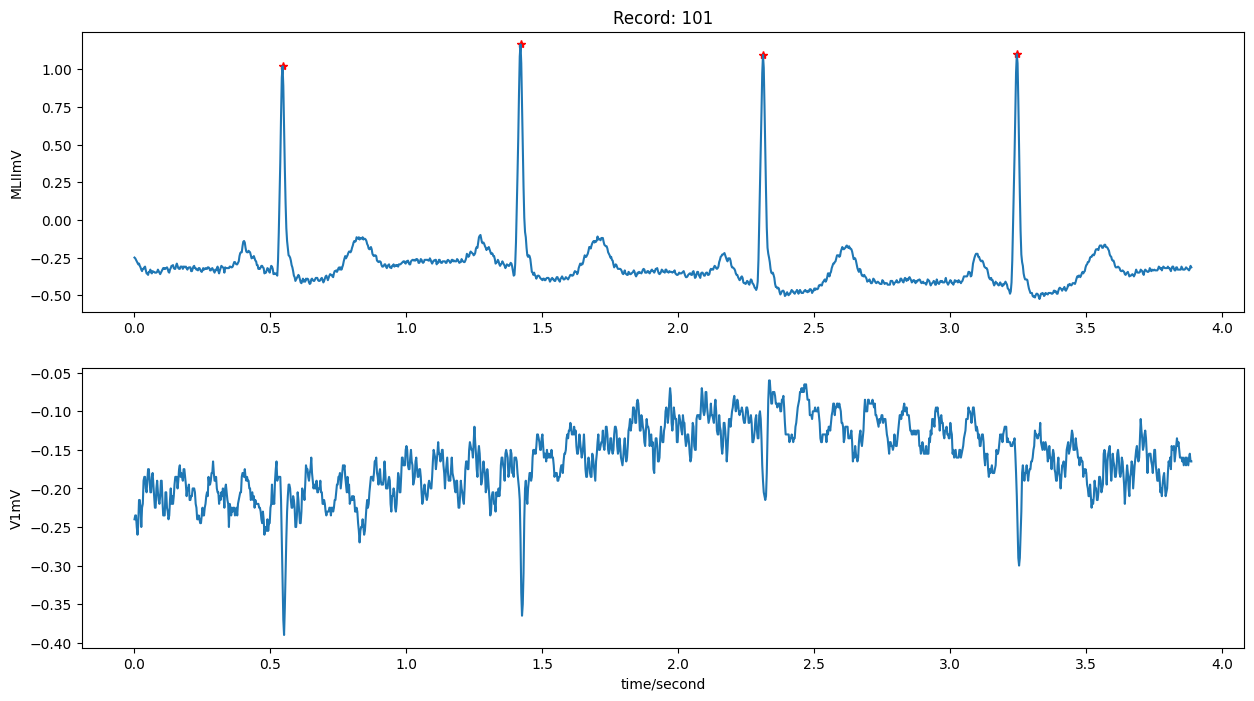

360


In [ ]:
data = 101

filename = f'/content/mit-bih-arrhythmia-database-1.0.0/{str(data)}'
record = wfdb.rdrecord(filename, sampfrom=200, sampto=length,)
ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T, columns=['TimeStamp','ecg'])
input = ecg.iloc[:,1]
annotation = wfdb.rdann(filename, 'atr', sampfrom=200, sampto=length,shift_samps=True)
Fs = annotation.fs
wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds',figsize=(15,8))

print(annotation.fs)

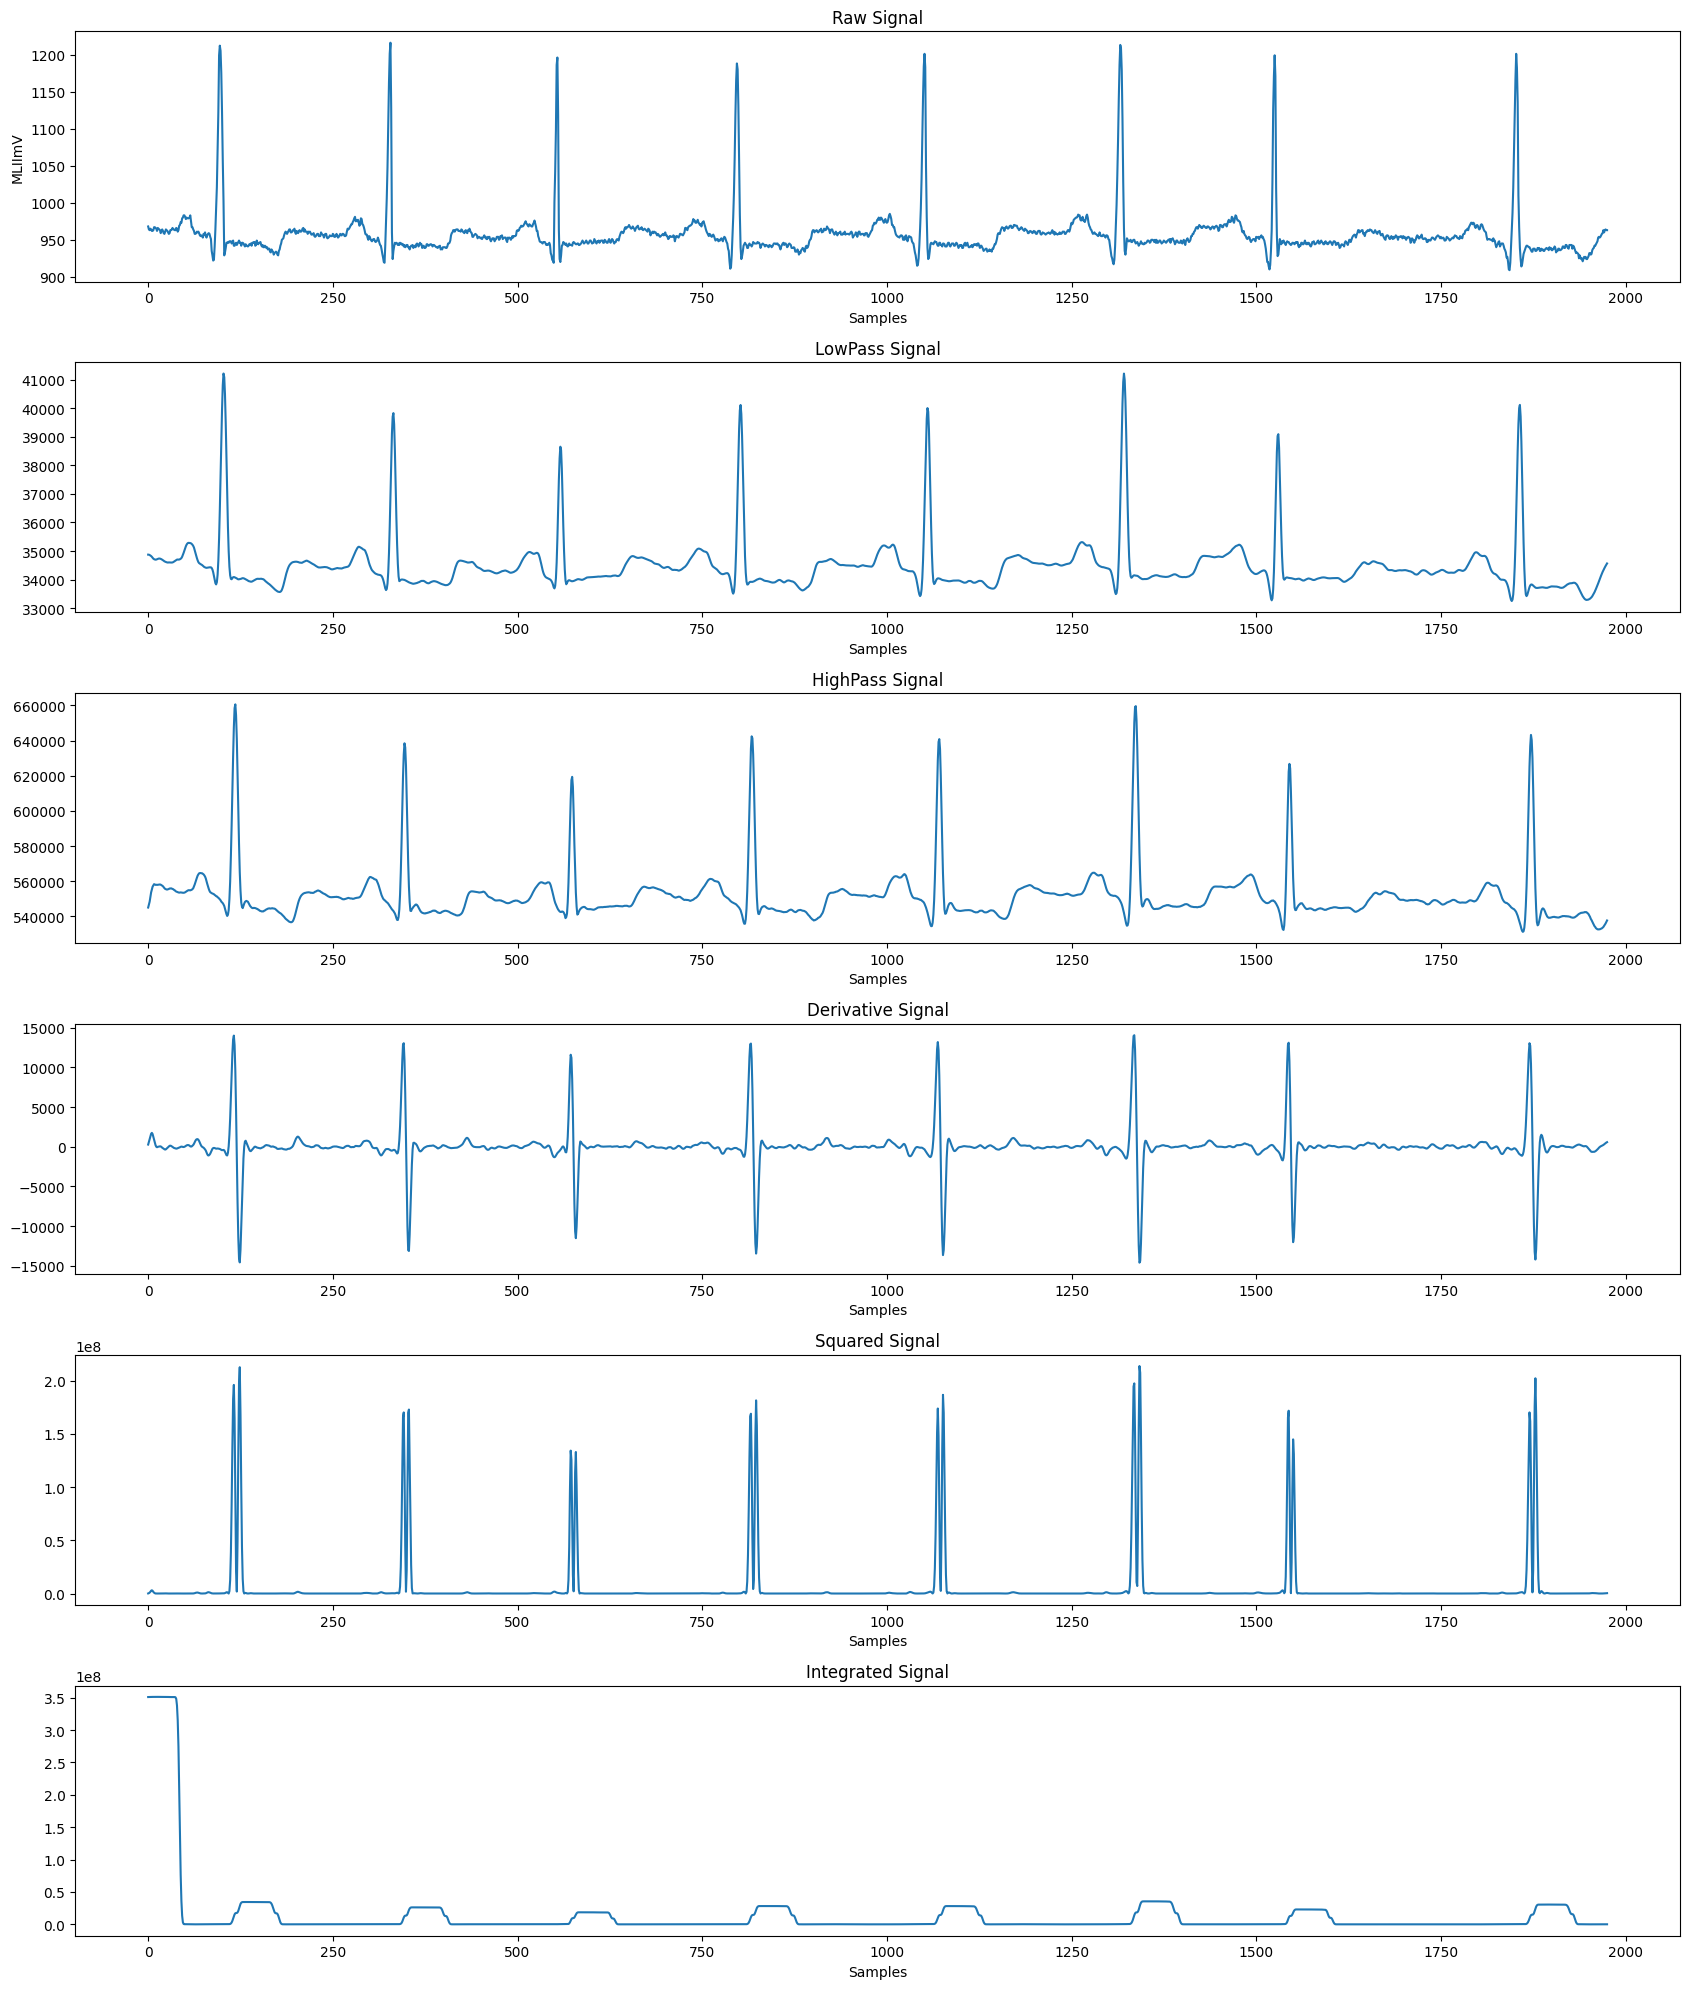

Text(0.5, 1.0, 'Peak Detection')

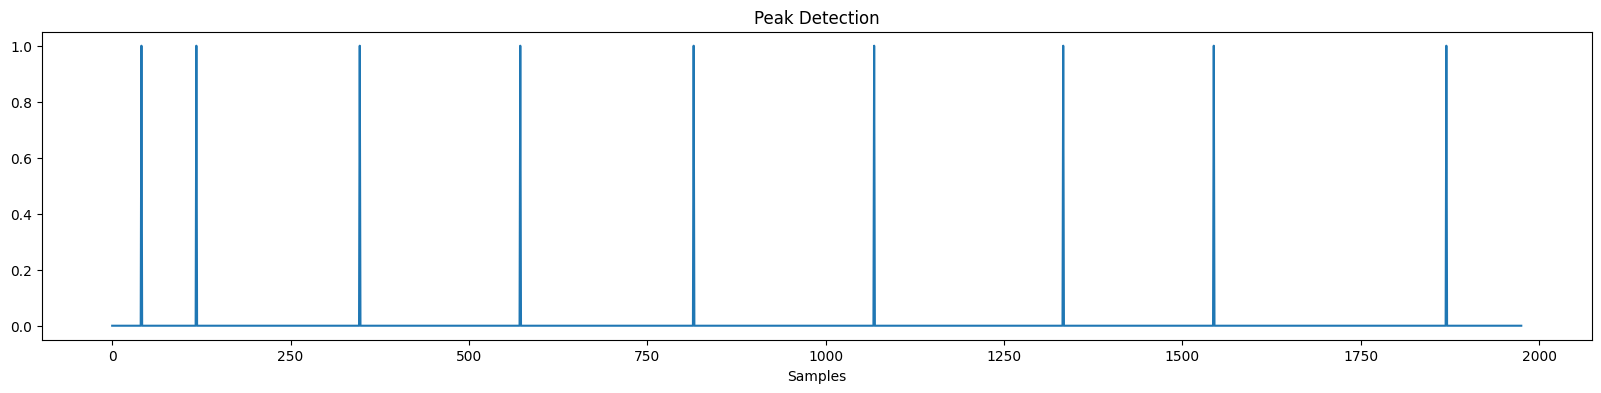

In [ ]:
fig, axs = plt.subplots(6, 1, figsize=(17, 20))

axs[0].plot(test_data_r[32:len(test_data_r)-2])
axs[0].set_title("Raw Signal")
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('MLIImV')

axs[1].plot(test_data_l[32:len(test_data_l)-2])
axs[1].set_title("LowPass Signal")
axs[1].set_xlabel('Samples')

axs[2].plot(test_data_h[32:len(test_data_h)-2])
axs[2].set_title("HighPass Signal")
axs[2].set_xlabel('Samples')

axs[3].plot(test_data_d[32:len(test_data_d)-2])
axs[3].set_title("Derivative Signal")
axs[3].set_xlabel('Samples')

axs[4].plot(test_data_s[32:len(test_data_s)-2])
axs[4].set_title("Squared Signal")
axs[4].set_xlabel('Samples')

axs[5].plot(test_data_w[32:len(test_data_w)-2])
axs[5].set_title("Integrated Signal")
axs[5].set_xlabel('Samples')

plt.tight_layout()
plt.show()

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(list(map(int, test_data_o[32:len(test_data_o)-2])))
plt.xlabel('Samples')
plt.title("Peak Detection")